In [405]:
from pynq import Overlay
from qsystem_2 import *
from qsystem2_asm import *
from scipy import signal
import warnings

In [406]:
soc = PfbSoc('qsystem_2.bit', force_init_clks=False)

In [416]:
scopeMode = False

qubitChannel = 5
cavityChannel = 4
readoutChannel = 0

qubitStartFrequency = 10
qubitDeltaFrequency = 0
qubitStartGain = 10000
qubitDeltaGain = 5000

cavityStartFrequency = 500
cavityDeltaFrequency = 0
cavityStartGain = 32767
cavityDeltaGain = 10

qubitFirstPulseWidthStart = 100
qubitFirstPulseWidthDelta = 0
qubitSecondPulseWidthStart = 0
qubitSecondPulseWidthDelta = 0

qubitFirstPulsePhaseStart = 0
qubitFirstPulsePhaseDelta = 0
qubitSecondPulsePhaseStart = 0
qubitSecondPulsePhaseDelta = 0

cavityPulseWidthStart = 100
cavityPulseWidthDelta = 50

interPulseDelayStart = 0
interPulseDelayDelta = 0
preReadoutDelayStart = 0
preReadoutDelayDelta = 0
postReadoutDelayStart = 100
postReadoutDelayDelta = 0

frequencyLoopCount = 1
gainLoopCount = 1
pulseWidthLoopCount = 1
delayLoopCount = 1
phaseLoopCount = 1
iterationLoopCount = 5

qEnvelope = False
cEnvelope = False

qEnvAddr = 0
cEnvAddr = 0

qToneEnable = False
cToneEnable = False

tOffset = 200
tDuration = 10

readoutChannelEnable = [True,True]

In [417]:
with ASM_Program() as p:
    
    ###################
    # DATA FORMATTING #
    ###################
    
    #Set up the pulse generator mode registers
    qgenMode = 0
    qgenMode += 0 if qToneEnable else 8 #set end value of a pulse to be zero as long as we aren't creating constant tones. 
    qgenMode += 4 if qToneEnable else 0 #Set the signal generator to constant tone if we are creating a tone. 
    qgenMode += 0 if qEnvelope else 1 #Set to product if we are using an envelope. Otherwise, set to dds. 
    qgenMode *= 2 ** 16 #Shift everything 16 bits to the left to or with pulseWidth later. 
    
    cgenMode = 0
    cgenMode += 0 if cToneEnable else 8 #set end value of a pulse to be zero as long as we aren't creating constant tones. 
    cgenMode += 4 if cToneEnable else 0 #Set the signal generator to constant tone if we are creating a tone. 
    cgenMode += 0 if cEnvelope else 1 #Set to product if we are using an envelope. Otherwise, set to dds.
    cgenMode *= 2 ** 16 #Shift everything 16 bits to the left to or with pulseWidth later. 
    
    print(cgenMode)
    
    tStart = tOffset
    tEnd = tOffset + tDuration
    
    tVal = 0
    tVal += 0x8000 if readoutChannelEnable[0] else 0
    tVal += 0x4000 if readoutChannelEnable[1] else 0
    
    frequencyLoopCount -= 1
    gainLoopCount -= 1
    pulseWidthLoopCount -= 1
    delayLoopCount -= 1
    phaseLoopCount -= 1
    iterationLoopCount -= 1
    
    qubitStartFrequencyReg = freq2reg(soc.fs_dac, qubitStartFrequency, B=32)
    qubitDeltaFrequencyReg = freq2reg(soc.fs_dac, qubitDeltaFrequency, B=32)
    cavityStartFrequencyReg = freq2reg(soc.fs_dac, cavityStartFrequency, B=32)
    cavityDeltaFrequencyReg = freq2reg(soc.fs_dac, cavityDeltaFrequency, B=32)
    
    ################
    # DATA STORAGE #
    ################
    
    #This data structure is a bit complex, but automates the register assignment and use. Register page within the tproc has a dictionary with values. A second dictionary is
    #automatically created that generates arbitrary addresses for the data. The variables can then be used in the actual ASM code by using the addresses dictionary. 
    
    vals = []
    signalPage = 0
    delayPage = 1
    loopPage = 2
    triggerPage = 3
    
    #Starting values for p0 registers
    #These registers hold everything for the signal generators (including some values that are swept)
    vals.append({
        #Frequency and gain to be swept by both qubit pulses
        'qsfreq' : qubitStartFrequencyReg, 
        'qdfreq' : qubitDeltaFrequencyReg, 
        'qsgain' : qubitStartGain, 
        'qdgain' : qubitDeltaGain, 
        
        #Frequency and gain to be swept by the cavity pulse
        'csfreq' : cavityStartFrequencyReg, 
        'cdfreq' : cavityDeltaFrequencyReg, 
        'csgain' : cavityStartGain, 
        'cdgain' : cavityDeltaGain, 
        
        #Phase values for the phases of the two qubit pulses. 
        'qfpps' : qubitFirstPulsePhaseStart, 
        'qfppd' : qubitFirstPulsePhaseDelta, 
        'qspps' : qubitSecondPulsePhaseStart, 
        'qsppd' : qubitSecondPulsePhaseDelta, 
        
        #Qubit and cavity pulse widths to be swept
        'qfpws' : qubitFirstPulseWidthStart, 
        'qfpwd' : qubitFirstPulseWidthDelta,  
        'qspws' : qubitSecondPulseWidthStart, 
        'qspwd' : qubitSecondPulseWidthDelta, 
        'cpws' : cavityPulseWidthStart, 
        'cpwd' : cavityPulseWidthDelta, 
        
        #Envelope Addresses
        'qenv' : qEnvAddr,
        'cenv' : cEnvAddr,
        
        #Pulse generator modes
        'qgenMode' : qgenMode,
        'cgenMode' : cgenMode, 
        
        'qfsettings' : 0, #Will be set inside the ASM
        'qssettings' : 0,
        'csettings' : 0, #Will be set inside the ASM 
    })
    
    #Starting values for p1 registers
    #These registers hold delay values (including some values that are swept)
    vals.append({
        #Delays
        'ipds' : interPulseDelayStart, 
        'ipdd' : interPulseDelayDelta, 
        'preRDS' : preReadoutDelayStart, 
        'preRDD' : preReadoutDelayDelta, 
        'postRDS' : postReadoutDelayStart, 
        'postRDD' : postReadoutDelayDelta, 
    })
    
    #Starting values for p2 registers
    #These registers hold the loop counts. 
    vals.append({
        'freqLoop' : frequencyLoopCount,
        'gainLoop' : gainLoopCount,
        'pwLoop' : pulseWidthLoopCount,
        'delLoop' : delayLoopCount,
        'phaseLoop' : phaseLoopCount,
        'iterLoop' : iterationLoopCount
    })
    
    #Starting values for p3 registers
    #These registers hold trigger data
    vals.append({
        'tstart' : tStart,
        'tend' : tEnd,
        'tval' : tVal, 
    })
    
    locs = []
    for page in range(len(vals)):
        locs.append({})
        for i, key in enumerate(vals[page]):
            locs[page][key] = i + 1
            
    ########################
    # DATA UPLOAD TO TPROC #
    ########################
        
    #Write the values to the ASM
    for page in range(len(vals)):
        for key in (locs[page]):
            p.regwi(page,locs[page][key],vals[page][key], f"Write value to register. Variable: {key} \tValue: {hex(vals[page][key])}\t{bin(vals[page][key])}")
    
    ###############
    # TPROC LOGIC #
    ###############

    p.synci(1000)
    
    #Frequency Loop Start
    p.label("FREQ_LOOP")
    
    #Gain Loop Start
    p.regwi(loopPage,locs[loopPage]['gainLoop'],vals[loopPage]['gainLoop'], f"Reset the gain loop value")
    p.regwi(signalPage,locs[signalPage]['qsgain'],vals[signalPage]['qsgain'], f"Reset the qubit gain value")
    p.regwi(signalPage,locs[signalPage]['csgain'],vals[signalPage]['csgain'], f"Reset the cavity gain value")
    p.label("GAIN_LOOP")
    
    #Pulse Width Loop Start
    p.regwi(loopPage,locs[loopPage]['pwLoop'],vals[loopPage]['pwLoop'], f"Reset the pulse width loop value")
    p.regwi(signalPage,locs[signalPage]['qfpws'],vals[signalPage]['qfpws'], f"Reset the qubit first pulse width")
    p.regwi(signalPage,locs[signalPage]['qspws'],vals[signalPage]['qspws'], f"Reset the qubit second pulse width")
    p.regwi(signalPage,locs[signalPage]['cpws'],vals[signalPage]['cpws'], f"Reset the cavity pulse width")
    p.label("PW_LOOP")
    p.bitw(signalPage, locs[signalPage]['qfsettings'], locs[signalPage]['qgenMode'], "|", locs[signalPage]['qfpws'], "Combine pulse width and settings to format the settings register.")
    p.bitw(signalPage, locs[signalPage]['qssettings'], locs[signalPage]['qgenMode'], "|", locs[signalPage]['qspws'], "Combine pulse width and settings to format the settings register.")
    p.bitw(signalPage, locs[signalPage]['csettings'], locs[signalPage]['cgenMode'], "|", locs[signalPage]['cpws'], "Combine pulse width and settings to format the settings register.")
    
    #Delay Loop Start
    p.regwi(loopPage,locs[loopPage]['delLoop'],vals[loopPage]['delLoop'], f"Reset the delay loop value")
    p.regwi(delayPage,locs[delayPage]['ipds'],vals[delayPage]['ipds'], f"Reset the inter-pulse delay width")
    p.regwi(delayPage,locs[delayPage]['preRDS'],vals[delayPage]['preRDS'], f"Reset the pre-readout delay width")
    p.regwi(delayPage,locs[delayPage]['postRDS'],vals[delayPage]['postRDS'], f"Reset the post-readout delay width")
    p.label("DEL_LOOP")
    
    #Phase Loop Start
    p.regwi(loopPage,locs[loopPage]['phaseLoop'],vals[loopPage]['phaseLoop'], f"Reset the phase loop value")
    p.regwi(signalPage,locs[signalPage]['qfpps'],vals[signalPage]['qfpps'], f"Reset the qubit first pulse phase")
    p.regwi(signalPage,locs[signalPage]['qspps'],vals[signalPage]['qspps'], f"Reset the qubit second pulse phase")
    p.label("PHASE_LOOP")
    
    #Iteration Loop Start
    p.regwi(loopPage,locs[loopPage]['iterLoop'],vals[loopPage]['iterLoop'], f"Reset the gain loop value")
    p.label("ITER_LOOP")
    
    ###################
    # ASM PULSE TRAIN # # Section where the actual pulses are generated. This will be looped with whatever changes come from the loops
    ###################
    
    if scopeMode: #If scopeMode is enabled, simply set the trigger once at the beginning of the pulse train. 
        p.set(0, triggerPage, locs[triggerPage]['tval'], 0, 0, 0, 0, locs[triggerPage]['tstart'])
        p.set(0, triggerPage, 0, 0, 0, 0, 0, locs[triggerPage]['tend'])
    
    p.set(qubitChannel, signalPage, locs[signalPage]['qsfreq'], locs[signalPage]['qfpps'], locs[signalPage]['qenv'], locs[signalPage]['qsgain'], locs[signalPage]['qfsettings'], 0)
    
    p.sync(signalPage,locs[signalPage]['qfpws']) #Delay for the pulse width 
    p.sync(delayPage, locs[delayPage]['ipds'], "Inter-pulse delay")
    
    p.set(qubitChannel, signalPage, locs[signalPage]['qsfreq'], locs[signalPage]['qspps'], locs[signalPage]['qenv'], locs[signalPage]['qsgain'], locs[signalPage]['qssettings'], 0)
    
    p.sync(signalPage,locs[signalPage]['qspws']) #Delay for the pulse width
    p.sync(delayPage, locs[delayPage]['preRDS'], "Pre-readout delay")
    
    p.set(cavityChannel, signalPage, locs[signalPage]['csfreq'], 0, locs[signalPage]['cenv'], locs[signalPage]['csgain'], locs[signalPage]['csettings'], 0) #Note, cavity pulse does not have a phase.
    
    if scopeMode is False: #Only trigger continuously if scopeMode is set to False. This will allow each pulse to be captured. 
        p.set(0, triggerPage, locs[triggerPage]['tval'], 0, 0, 0, 0, locs[triggerPage]['tstart'])
        p.set(0, triggerPage, 0, 0, 0, 0, 0, locs[triggerPage]['tend'])
    
    p.sync(delayPage, locs[delayPage]['postRDS'], "Post-readout delay")
    
    #######################
    # END ASM PULSE TRAIN #
    #######################
    
    #Iteration Loop End
    p.loopnz(loopPage,locs[loopPage]['iterLoop'], "ITER_LOOP")
    
    #Phase Loop End
    p.math(signalPage, locs[signalPage]['qfpps'], locs[signalPage]['qfpps'], "+", locs[signalPage]['qfppd'], "Increment the qubit first pulse phase")
    p.math(signalPage, locs[signalPage]['qspps'], locs[signalPage]['qspps'], "+", locs[signalPage]['qsppd'], "Increment the qubit second pulse phase") 
    p.loopnz(loopPage,locs[loopPage]['phaseLoop'], "PHASE_LOOP")
    
    #Delay Loop End
    p.math(delayPage, locs[delayPage]['ipds'], locs[delayPage]['ipds'], "+", locs[delayPage]['ipdd'], "Increment the inter-pulse delay width")
    p.math(delayPage, locs[delayPage]['preRDS'], locs[delayPage]['preRDS'], "+", locs[delayPage]['preRDD'], "Increment the pre-readout delay width") 
    p.math(delayPage, locs[delayPage]['postRDS'], locs[delayPage]['postRDS'], "+", locs[delayPage]['postRDS'], "Increment the post-readout delay width")
    p.loopnz(loopPage,locs[loopPage]['delLoop'], "DEL_LOOP")
    
    #Pulse Width Loop End
    p.math(signalPage, locs[signalPage]['qfpws'], locs[signalPage]['qfpws'], "+", locs[signalPage]['qfpwd'], "Increment the qubit first pulse width")
    p.math(signalPage, locs[signalPage]['qspws'], locs[signalPage]['qspws'], "+", locs[signalPage]['qspwd'], "Increment the qubit second pulse width") 
    p.math(signalPage, locs[signalPage]['cpws'], locs[signalPage]['cpws'], "+", locs[signalPage]['cpwd'], "Increment the cavity pulse width")
    p.loopnz(loopPage,locs[loopPage]['pwLoop'], "PW_LOOP")
    
    #Gain Loop End
    p.math(signalPage, locs[signalPage]['qsgain'], locs[signalPage]['qsgain'], "+", locs[signalPage]['qdgain'], "Increment the qubit gain")
    p.math(signalPage, locs[signalPage]['csgain'], locs[signalPage]['csgain'], "+", locs[signalPage]['cdgain'], "Increment the cavity gain") 
    p.loopnz(loopPage,locs[loopPage]['gainLoop'], "GAIN_LOOP")
    
    #Frequency Loop End
    p.math(signalPage, locs[signalPage]['qsfreq'], locs[signalPage]['qsfreq'], "+", locs[signalPage]['qdfreq'], "Increment the qubit frequency")
    p.math(signalPage, locs[signalPage]['csfreq'], locs[signalPage]['csfreq'], "+", locs[signalPage]['cdfreq'], "Increment the cavity frequency") 
    p.loopnz(loopPage,locs[loopPage]['freqLoop'], "FREQ_LOOP")

589824


In [418]:
# print(p) #Print the ASM
soc.tproc.load_asm_program(p) #Upload the data. 

In [419]:
#########################
# SETUP READOUT CHANNEL #
#########################

soc.readouts[readoutChannel].set_out("product")
soc.readouts[readoutChannel].set_freq(cavityStartFrequency) 
# soc.avg_bufs[readoutChannel].config(address = readoutChannel, length = 1022) 
soc.avg_bufs[readoutChannel].config(address = readoutChannel, length = cavityPulseWidthStart) 
soc.avg_bufs[readoutChannel].enable()

In [420]:
###############
# START TPROC #
###############

soc.tproc.stop()
soc.tproc.start()

In [421]:
#########################
# GET DECIMATED SAMPLES #
#########################

idec,qdec = soc.get_decimated(readoutChannel, length=1022)

In [422]:
###########################
# GET ACCUMULATED SAMPLES #
###########################
length = 1
for key in vals[loopPage]:
    length *= (vals[loopPage][key] + 1)
print(length)
iacc,qacc = soc.get_accumulated(readoutChannel, length=length)

5


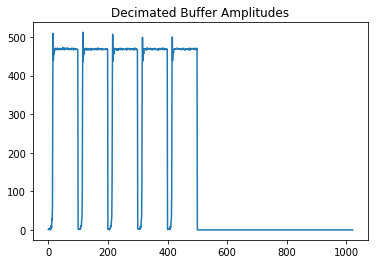

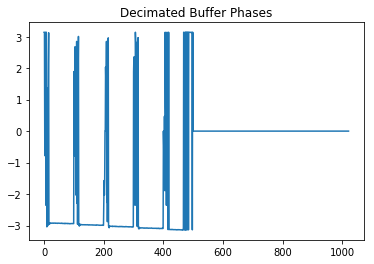

In [423]:
amps = np.abs(idec + 1j * qdec)
phases = np.angle(idec + 1j * qdec)

plt.plot(amps)
plt.title("Decimated Buffer Amplitudes")
plt.show()
plt.plot(phases)
plt.title("Decimated Buffer Phases")
plt.show()

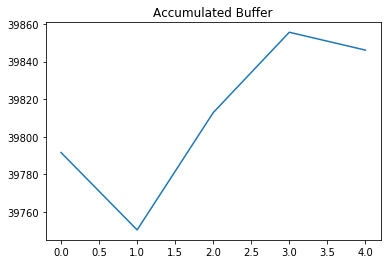

In [424]:
amps = np.abs(iacc + 1j * qacc)

plt.plot(amps)
plt.title("Accumulated Buffer")
plt.show()